# Part 2B - NLP EDA of Amazon Reviews for Miracle Noodles

In this notebook we will continue with the data we prepared in the last notebook.  
Our goals will be:
- to separate the data into high and low ratings groups to compare them
- use wordclouds, n-grams, and other EDA tools to compare groups
- then to create a model to classify future Ratings as having a high or low sentiment.

In [2]:
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    info = f.read()

display(Markdown(info))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

# Part 2B - NLP EDA - Movie Reviews

In [3]:
!pip install -U dojo_ds -q
import dojo_ds as ds
# ds.__version__

In [4]:
import matplotlib.pyplot as plt
import missingno
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import os, json
from pprint import pprint
pd.set_option("display.max_columns",50)
# pd.set_option('display.max_colwidth', 250)

# fav_style = ('ggplot','tableau-colorblind10')
# fav_context  ={'context':'notebook', 'font_scale':1.1}
# plt.style.use(fav_style)
# sns.set_context(**fav_context)
# plt.rcParams['savefig.transparent'] = False
# plt.rcParams['savefig.bbox'] = 'tight'

In [5]:
FPATHS_FILE = "config/filepaths.json"

with open(FPATHS_FILE) as f:
    FPATHS = json.load(f)
FPATHS.keys()

dict_keys(['data', 'images', 'metadata', 'eda', 'models'])

In [6]:
FPATHS['data'].keys()

dict_keys(['raw', 'cleaned', 'subset', 'processed-nlp', 'app', 'ml-nlp', 'nn-nlp'])

In [7]:
FPATHS['data']['processed-nlp']

{'processed-reviews-spacy_json': 'data/processed/processed-reviews.json',
 'processed-reviews-spacy_joblib': 'data/processed/processed-reviews.joblib',
 'processed-reviews-with-target_json': 'data/processed/processed-reviews-with-target.json',
 'processed-reviews-with-target_joblib': 'data/processed/processed-reviews-with-target.joblib'}

In [8]:
FPATHS['data']['ml-nlp']

{'train_joblib': 'data/modeling/training-data.joblib',
 'test_joblib': 'data/modeling/testing-data.joblib'}

In [9]:
# Fpath for saving final df with target columns
fpath_out_ml_with_targets = FPATHS['data']['processed-nlp']['processed-reviews-with-target_json']
fpath_out_ml_with_targets

'data/processed/processed-reviews-with-target.json'

In [10]:
## If using json
reviews_fpath = FPATHS['data']['processed-nlp']['processed-reviews-spacy_json']
reviews_fpath

'data/processed/processed-reviews.json'

In [11]:
df = pd.read_json(reviews_fpath)
# df = df.reset_index(drop=False)
df

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shira...,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Go for the green noodles: The herb flavor make...,Go for the green noodles: The herb flavor make...,"[go, for, the, green, noodles, the, herb, flav...","[green, noodles, herb, flavor, makes, odd, tex...","[green, noodle, herb, flavor, make, odd, textu...",go for the green noodles the herb flavor makes...,green noodles herb flavor makes odd texture sh...,green noodle herb flavor make odd texture shir...
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half fil...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Its an awesome substitute.: I didn't have a pr...,Its an awesome substitute.: I didn't have a pr...,"[its, an, awesome, substitute, i, did, n't, ha...","[awesome, substitute, problem, half, filled, b...","[awesome, substitute, problem, half, fill, bag...",its an awesome substitute i did n't have a pro...,awesome substitute problem half filled bag use...,awesome substitute problem half fill bag user ...
4,B007JINB0W,AH3B94LQOPPY6,They taste like whatever you cook them with.,Five Stars,5,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Five Stars: They taste like whatever you cook ...,Five Stars: They taste like whatever you cook ...,"[five, stars, they, taste, like, whatever, you...","[stars, taste, like, cook]","[star, taste, like, cook]",five stars they taste like whatever you cook t...,stars taste like cook,star taste like cook
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,A73IG1ED6S0JR,Product arrived with two of the bags punctured...,would not recomend,1,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,would not recomend: Product arrived with two o...,would not recomend: Product arrived with two o...,"[would, not, recomend, product, arrived, with,...","[recomend, product, arrived, bags, punctured, ...","[recomend, product, arrive, bag, puncture, sme...",would not recomend product arrived with two of...,recomend product arrived bags punctured smells...,recomend product arrive bag puncture smell bad
4359,B007JINB0W,A1XZ2H0MYG54M0,Ok.,Five Stars,5,2016,"Miracle Noodle Zero Carb, Glute

In [12]:
# Check for duplciate review ids
dup_subset_cols = ['asin','reviewerID','review-text-full']
df.duplicated(subset=dup_subset_cols).sum()

0

In [13]:
# Check for duplicated review text
df.duplicated(subset=['review-text-full']).sum()

42

In [14]:
df.isna().sum()

asin                    0
reviewerID              0
reviewText              0
summary                 0
overall                 0
year                    0
title                   0
brand                   0
category                0
review-text-full        0
review-text-full_raw    0
tokens-dirty            0
tokens                  0
lemmas                  0
tokens-dirty-joined     0
tokens-joined           0
lemmas-joined           0
dtype: int64

<Axes: >

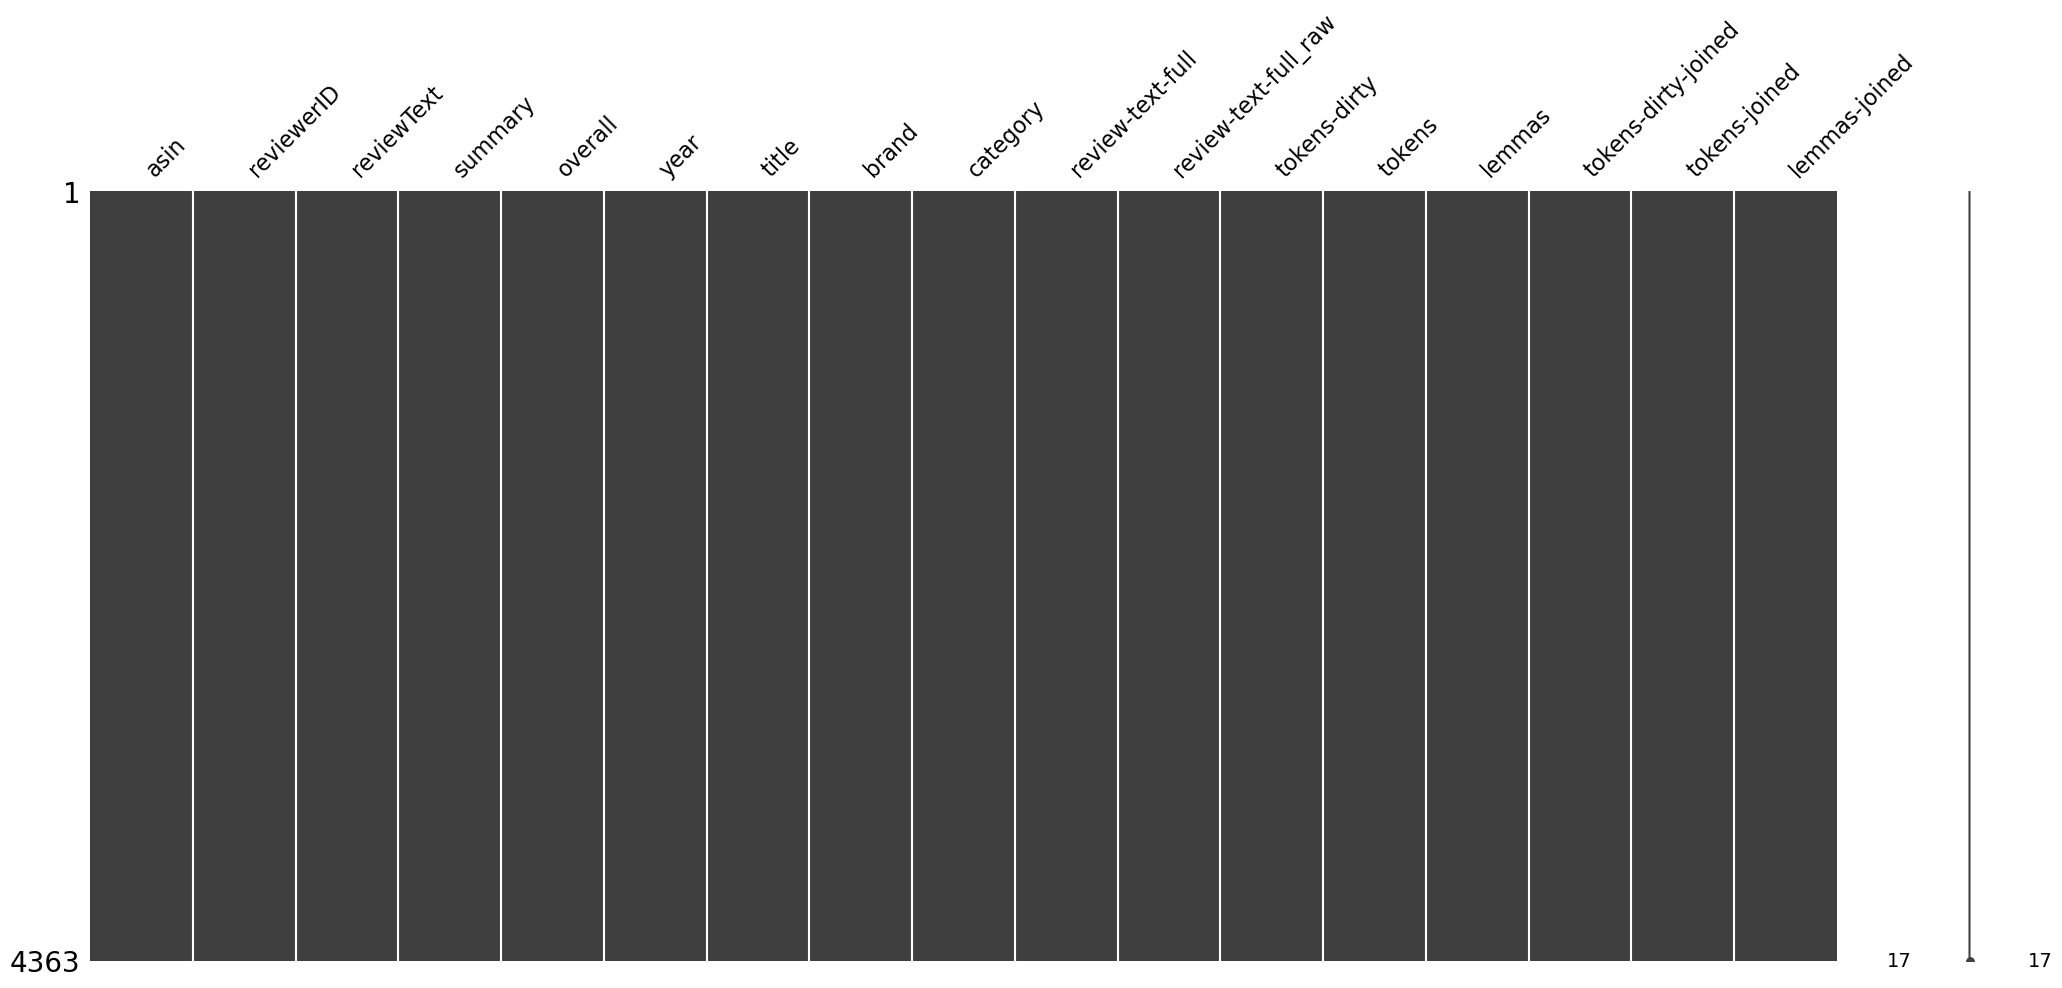

In [15]:
import missingno
missingno.matrix(df)

## Set Groups (for EDA & Modeling)

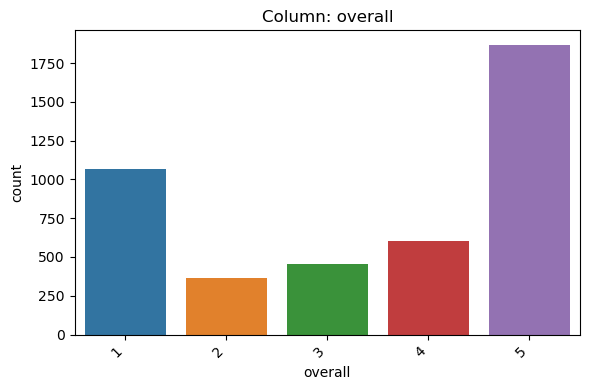

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: '5' occurs 1868 times (42.81%)


In [16]:
ds.eda.explore_categorical(df,x='overall');

To understand what customers do and do not like about Hoover products, we will define 2 groups:
- High Ratings
    - Overall rating = 5.0
- Low Ratings
    - Overall rating = 1.0 or 2.0


We can use a function and .map to define group names based on the numeric overall ratings.

### Define Target Groups (02/08)

Binary:
- "High Rating": = 5
- "Low Rating": <= 2
<!-- 
Multiclass:
- "High Rating": >= 8
- "Mid Rating": 4< x < 8
- "Low Rating": <4 -->

In [17]:
def create_groups(x):
    if x>=5.0:
        return "High"
    elif x <=2.0:
        return "Low"
    else: 
        return None
    

# def set_groups_multi(x):
#     if x >= 8:
#         group = "High"
#     elif x>=4:
#         group = "Mid"
#     else:
#         group= "Low"
#     return group

In [18]:
df['target-rating'] = df['overall'].map(create_groups)#set_group_binary)
df['target-rating'].value_counts(dropna=False)

High    1868
Low     1437
None    1058
Name: target-rating, dtype: int64

### Class Balance

It's always a good idea to check the class balance when creating a classification model.  This can affect modeling bias and interpretation of metrics.

In [19]:
df['target-rating'].value_counts(dropna=True, normalize=True)

High    0.565204
Low     0.434796
Name: target-rating, dtype: float64

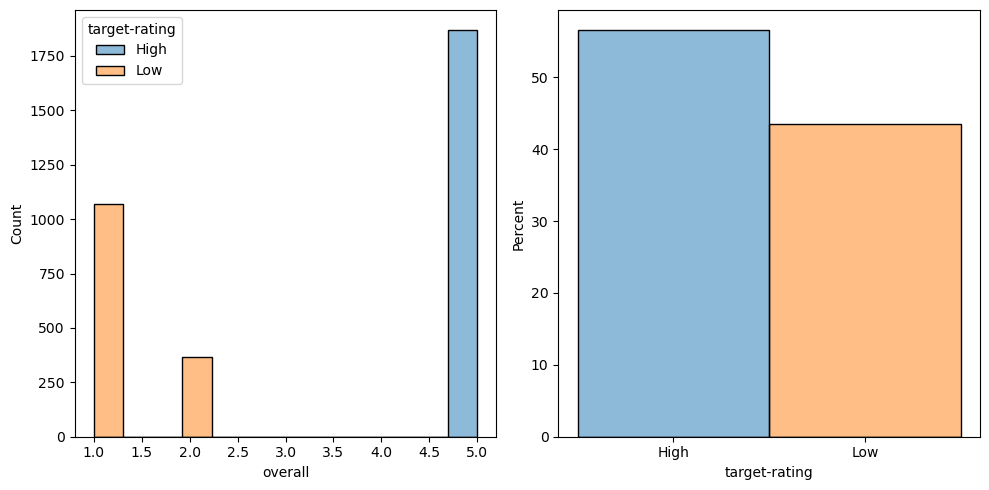

In [20]:
fig, axes =  plt.subplots(ncols=2, figsize=(10,5))
sns.histplot(data=df, x='overall', hue='target-rating', ax=axes[0])
sns.histplot(data=df, x='target-rating', hue='target-rating', ax=axes[1], legend=False, stat='percent')
fig.tight_layout()

#### Save Reviews with Target for Modeling (Part 3)

In [21]:
df.head()

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...,None
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shira...,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Go for the green noodles: The herb flavor make...,Go for the green noodles: The herb flavor make...,"[go, for, the, green, noodles, the, herb, flav...","[green, noodles, herb, flavor, makes, odd, tex...","[green, noodle, herb, flavor, make, odd, textu...",go for the green noodles the herb flavor makes...,green noodles herb flavor makes odd texture sh...,green noodle herb flavor make odd texture shir...,High
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half fil...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Its an awesome substitute.: I didn't have a pr...,Its an awesome substitute.: I didn't have a pr...,"[its, an, awesome, substitute, i, did, n't, ha...","[awesome, substitute, problem, half, filled, b...","[awesome, substitute, problem, half, fill, bag...",its an awesome substitute i did n't have a pro...,awesome substitute problem half filled bag use...,awesome substitute problem half fill bag user ...,High
4,B007JINB0W,AH3B94LQOPPY6,They taste like whatever you cook them with.,Five Stars,5,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Five Stars: They taste like whatever you cook ...,Five Stars: They taste like whatever you cook ...,"[five, stars, they, taste, like, whatever, you...","[stars, taste, like, cook]","[star, taste, like, cook]",five stars they taste like whatever you cook t...,stars taste like cook,star taste like cook,High


In [22]:
fpath_out_ml_with_targets =  FPATHS['data']['processed-nlp']['processed-reviews-with-target_json']
fpath_out_ml_with_targets

'data/processed/processed-reviews-with-target.json'

In [23]:
FPATHS['data']['processed-nlp']

{'processed-reviews-spacy_json': 'data/processed/processed-reviews.json',
 'processed-reviews-spacy_joblib': 'data/processed/processed-reviews.joblib',
 'processed-reviews-with-target_json': 'data/processed/processed-reviews-with-target.json',
 'processed-reviews-with-target_joblib': 'data/processed/processed-reviews-with-target.joblib'}

In [24]:
# Save to json
df.to_json(fpath_out_ml_with_targets)

In [25]:
# Test saved json file
pd.read_json(fpath_out_ml_with_targets)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...,None
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shira...,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Go for the green noodles: The herb flavor make...,Go for the green noodles: The herb flavor make...,"[go, for, the, green, noodles, the, herb, flav...","[green, noodles, herb, flavor, makes, odd, tex...","[green, noodle, herb, flavor, make, odd, textu...",go for the green noodles the herb flavor makes...,green noodles herb flavor makes odd texture sh...,green noodle herb flavor make odd texture shir...,High
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half fil...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Its an awesome substitute.: I didn't have a pr...,Its an awesome substitute.: I didn't have a pr...,"[its, an, awesome, substitute, i, did, n't, ha...","[awesome, substitute, problem, half, filled, b...","[awesome, substitute, problem, half, fill, bag...",its an awesome substitute i did n't have a pro...,awesome substitute problem half filled bag use...,awesome substitute problem half fill bag user ...,High
4,B007JINB0W,AH3B94LQOPPY6,They taste like whatever you cook them with.,Five Stars,5,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Five Stars: They taste like whatever you cook ...,Five Stars: They taste like whatever you cook ...,"[five, stars, they, taste, like, whatever, you...","[stars, taste, like, cook]","[star, taste, like, cook]",five stars they taste like whatever you cook t...,stars taste like cook,star taste like cook,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,A73IG1ED6S0JR,Product arrived with two of the bags punctured...,would not recomend,1,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,would not recomend: Product arrived with two o...,would not recomend: Product arrived with two o...,"[would, not, recomend, product, arrived, with,...","[recomend, product, arrived, bags, punctured, ...","[recomend, product, arrive, bag, puncture, sme...",would not recomend product arrived with two of...,recomend product arrived bags punctured smells...,recomend product arrive bag puncture smell bad,Low
4359,B007JINB0W,A1XZ2H0MYG54M0,Ok.,Fiv

In [26]:
FPATHS['data']['processed-nlp']['processed-reviews-with-target_joblib']

'data/processed/processed-reviews-with-target.joblib'

In [27]:
import joblib
joblib.dump(df, FPATHS['data']['processed-nlp']['processed-reviews-with-target_joblib'],compress=9)

['data/processed/processed-reviews-with-target.joblib']

In [28]:
# Saving MVP test case 
mvp_cols = ['reviewerID','review-text-full',
            'overall',
            'target-rating']
df[mvp_cols]

,reviewerID,review-text-full,overall,target-rating
0,A3Y51NV9HU5T2,"Four Stars: Great pasta taste and feel, but th...",4,None
1,A3D7EFSRC6Y9MP,Okay but don't like texture: The texture just ...,3,None
2,A4AM5KBP3I2R,Go for the green noodles: The herb flavor make...,5,High
3,A3GHK4IL78DB7Y,Its an awesome substitute.: I didn't have a pr...,5,High
4,AH3B94LQOPPY6,Five Stars: They taste like whatever you cook ...,5,High
...,...,...,...,...
4358,A73IG1ED6S0JR,would not recomend: Product arrived with two o...,1,Low
4359,A1XZ2H0MYG54M0,Five Stars: Ok.,5,High
4360,A3I2YF0MXB7P0B,"Not awful, but now I know why these were on sa...",2,Low
4361,A2UELLFLITPMT1,Don't even try it.: Truly horrific. Like eatin...,1,Low


In [29]:
fpath_llm = FPATHS['data']['app']['reviews-with-target-for-llm_csv']
df[mvp_cols].to_csv(fpath_llm, index=False)

# Part 2) EDA and Visualization

**2) EDA and Visualization:**

- Create word clouds to visualize the most frequent and significant words in each group.
    - Remember, you can use this analysis to identify additional custom EDA stop words to use for visualization. (e.g., if the words are common in both groups)
    - **Save your wordclouds as .png files in the "Images/" folder in your repo.**



- Apply nltk's `FreqDist` class to compare the frequency distribution of words in the review groups.
    - Remember, you can use this analysis to identify additional custom EDA stop words to use for visualization. (e.g., if the words are common in both groups)
    - **Save your freq dist plots as .png files in the "Images/" folder in your repo.**



- Perform n-grams analysis (bigrams and trigrams),
    - Remember, you can use this analysis to identify additional custom stop words to use for EDA. (e.g., if the words are common in both groups)
    - Focus on bigrams or trigrams, using NLTK's `BigramCollocationFinder` and BigramAssocMeasures classes (or the Trigram equivalent Finder and Measures) to explore commonly used groups of words for each rating-group.
    - Describe any differences. What do these differences tell you?
    - `Save your...`?



- Perform sentiment analysis to create polarity scores according to VADERS's sentiment lexicon.

    - Compare the sentiments of high-rating and low-rating texts.

    - Compare the average sentiment scores for high and low-rating reviews.

    - Which review polarity scores don't match the ratings? Why do you think this is?

        

**3) Evaluation and Reporting:**

- Based on your analyses, what should someone do (or not do) if they want to make a highly-rated movie?
    - List 3 things associated with high-rating reviews
    - List 3 things associated with low-rating reviews.

> Adding imports as-if standalone notebook

In [29]:
import matplotlib.pyplot as plt
import missingno
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd

import spacy
# nlp_custom = fn.nlp.make_custom_nlp(disable=['ner','parser'],contractions=[],
#                             stopwords_to_add=["★"])
# nlp_custom
# # Disable parser and ner
# # nlp_light = spacy.load("en_core_web_sm", disable=['parser','ner'])

## Divide by Group

Since we want to compare and classify high rating reviews vs low-rating reviews, we will create 2 different dataframes: 

In [30]:
df.head(2)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...,None


In [31]:
# Set text and target group columns:
text_col = 'review-text-full'
target_col = 'target-rating'
print(df[target_col].value_counts(dropna=False))

print("\n- Preview class balance:")
print(df[target_col].value_counts(normalize=True))

High    1868
Low     1437
None    1058
Name: target-rating, dtype: int64

- Preview class balance:
High    0.565204
Low     0.434796
Name: target-rating, dtype: float64


## Separate Groups for Visualization

In [32]:
# Create a filter for each group
filter_low = df[target_col] == "Low"#"Low"
filter_high = df[target_col] == "High"
filter_low.sum(), filter_high.sum()

(1437, 1868)

In [33]:
# Save the filtered texts for high rating group
high_reviews_text = " ".join( df.loc[filter_high, text_col])
high_reviews_text[:100]

'Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable. It'

In [34]:
# Save the filtered texts for low rating group
low_reviews_text = " ".join( df.loc[filter_low, text_col])
low_reviews_text[:100]

"NOT A GOOD TASTE: Taste so bad. the noodles and rice fill like rubber in texture and don't absorb th"

In [35]:
# Make a single giant string with entire groups tokens
high_reviews_tokens = " ".join( df.loc[filter_high, 'tokens-joined'])
low_reviews_tokens = " ".join( df.loc[filter_low, 'tokens-joined'])

high_reviews_lemmas =  " ".join( df.loc[filter_high, 'lemmas-joined'])
low_reviews_lemmas =  " ".join( df.loc[filter_low, 'lemmas-joined'])

In [36]:
# Create lists of all lemmas in both high and low review groups
high_review_tokens_list = df.loc[filter_high, 'tokens'].explode().astype(str).to_list()
low_review_tokens_list = df.loc[filter_low, 'tokens'].explode().astype(str).to_list()

high_review_lemmas_list = df.loc[filter_high, 'lemmas'].explode().astype(str).to_list()
low_review_lemmas_list = df.loc[filter_low, 'lemmas'].explode().astype(str).to_list()
high_review_tokens_list[:5], low_review_lemmas_list[:5]

(['green', 'noodles', 'herb', 'flavor', 'makes'],
 ['good', 'taste', 'taste', 'bad', 'noodle'])

## WordClouds

# ***BOOKMARK MID 02/08/2024***

In [37]:
from wordcloud import WordCloud, STOPWORDS

In [38]:

def plot_wordclouds(cloud_low, cloud_high, 
                    cloud_low_label="Low Ratings", 
                    cloud_high_label='High Ratings',
                    title='Comparing Word Usage', figsize=(8, 5), 
                    title_params ={'y':1.0,"fontsize":'xx-large'}):
    """Plots the wordlcouds for two groups"""
    ## Plot the Images
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    axes[1].imshow(high_cloud)
    axes[1].set_title(cloud_high_label)
    axes[1].axis('off')
    
    axes[0].imshow(low_cloud)
    axes[0].set_title(cloud_low_label)
    axes[0].axis('off')

    if title is not None:
        fig.suptitle(title,**title_params)#y=1.0, fontsize='xx-large')

    fig.tight_layout()    
    return fig


In [39]:
# Make word clouds of raw text
custom_stopwords = [*STOPWORDS, 'five','one','miracle','noodles','noodle']
custom_stopwords[:10],custom_stopwords[-5:]

(['themselves',
  'before',
  'between',
  'had',
  'own',
  "what's",
  "we've",
  'about',
  'why',
  'therefore'],
 ['five', 'one', 'miracle', 'noodles', 'noodle'])

In [40]:
FPATHS['eda']['wordclouds']['default-clouds-by-group_png']

'eda/default-wordclouds.png'

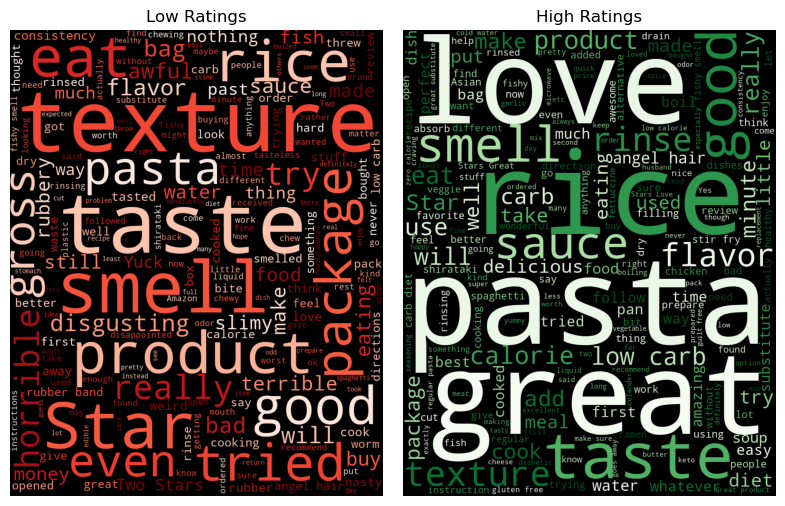

In [41]:
# Create an instance of a WordCloud and use the generate method
shared_cloud_kws = dict(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2,
                       stopwords=custom_stopwords
                       )

low_cloud = WordCloud(colormap="Reds", **shared_cloud_kws).generate(low_reviews_text)
high_cloud = WordCloud(colormap="Greens",**shared_cloud_kws).generate(high_reviews_text)
fig = plot_wordclouds(low_cloud, high_cloud, title=None)
fig.savefig(FPATHS['eda']['wordclouds']['default-clouds-by-group_png'], dpi=300, transparent=False, bbox_inches='tight')

### FreqDist

In [42]:
from nltk import ngrams, FreqDist

In [43]:
# Cleaning tokens for FreqDist Bigrams
freq_dist_stopwords = [*STOPWORDS,'one','five','star']
clean_low_review_tokens_list = [w.lower() for w in low_review_tokens_list if w not in STOPWORDS ]
clean_high_review_tokens_list = [w.lower() for w in high_review_lemmas_list if w not in STOPWORDS ]

clean_low_review_tokens_list[:10], clean_high_review_tokens_list[:10]

(['good',
  'taste',
  'taste',
  'bad',
  'noodles',
  'rice',
  'fill',
  'rubber',
  'texture',
  'absorb'],
 ['green',
  'noodle',
  'herb',
  'flavor',
  'make',
  'odd',
  'texture',
  'shirataki',
  'palatable',
  'awesome'])

In [44]:
# FreqDist of ngrams
low_ngrams_freq = FreqDist(ngrams(clean_low_review_tokens_list, 3))
low_ngrams_freq.most_common(n=25)

[(('chewing', 'rubber', 'bands'), 11),
 (('low', 'carb', 'diet'), 8),
 (('love', 'miracle', 'noodles'), 8),
 (('angel', 'hair', 'pasta'), 7),
 (('smell', 'goes', 'away'), 6),
 (('angel', 'hair', 'rice'), 6),
 (('threw', 'rest', 'away'), 5),
 (('low', 'carb', 'pasta'), 5),
 (('followed', 'directions', 'exactly'), 5),
 (('nt', 'waste', 'money'), 5),
 (('looking', 'low', 'carb'), 5),
 (('noodle', 'angel', 'hair'), 5),
 (('eating', 'rubber', 'bands'), 5),
 (('ended', 'throwing', 'away'), 5),
 (('tried', 'angel', 'hair'), 5),
 (('bowl', 'rubber', 'bands'), 4),
 (('smells', 'dead', 'fish'), 4),
 (('smell', 'open', 'package'), 4),
 (('star', 'taste', 'terrible'), 4),
 (('brand', 'shirataki', 'noodles'), 4),
 (('wrong', 'wrong', 'wrong'), 4),
 (('waste', 'time', 'money'), 4),
 (('noodles', 'angel', 'hair'), 4),
 (('nastiest', 'thing', 'mouth'), 4),
 (('save', 'money', 'eat'), 4)]

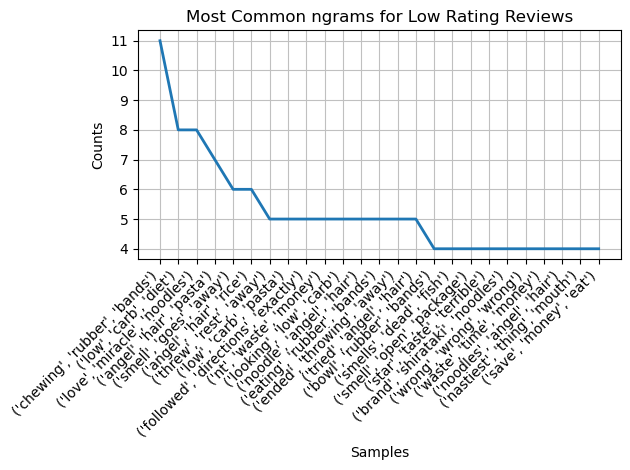

In [45]:
# Plot ngrams for low
ax = low_ngrams_freq.plot(25,show=False)
fig = ax.get_figure()
ax.set_title("Most Common ngrams for Low Rating Reviews")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', size=10);
fig.tight_layout()

In [46]:
# FreqDist of ngrams
high_ngrams_freq = FreqDist(ngrams(clean_high_review_tokens_list, 3))
high_ngrams_freq.most_common(n=25)

[(('low', 'carb', 'diet'), 87),
 (('great', 'low', 'carb'), 40),
 (('smell', 'go', 'away'), 33),
 (('rinse', 'cold', 'water'), 29),
 (('love', 'miracle', 'noodle'), 24),
 (('angel', 'hair', 'noodle'), 23),
 (('noodle', 'love', 'noodle'), 19),
 (('angel', 'hair', 'pasta'), 19),
 (('love', 'noodle', 'love'), 18),
 (('star', 'great', 'product'), 18),
 (('low', 'carb', 'lifestyle'), 17),
 (('great', 'stir', 'fry'), 15),
 (('follow', 'direction', 'package'), 15),
 (('rinse', 'rinse', 'rinse'), 14),
 (('try', 'angel', 'hair'), 14),
 (('noodle', 'low', 'carb'), 12),
 (('good', 'substitute', 'pasta'), 12),
 (('eat', 'low', 'carb'), 12),
 (('open', 'package', 'rinse'), 11),
 (('absorb', 'flavor', 'cook'), 11),
 (('low', 'carb', 'low'), 11),
 (('love', 'love', 'love'), 11),
 (('star', 'good', 'product'), 11),
 (('boil', '2', 'minute'), 11),
 (('gluten', 'free', 'noodle'), 10)]

### WordClouds from Raw Bigrams

In [47]:
# Get freqs from FreqDist as dictionary
low_freqs_dict = dict(low_ngrams_freq)
high_freqs_dict = dict(high_ngrams_freq)
list(low_freqs_dict.keys())[:10]

[('good', 'taste', 'taste'),
 ('taste', 'taste', 'bad'),
 ('taste', 'bad', 'noodles'),
 ('bad', 'noodles', 'rice'),
 ('noodles', 'rice', 'fill'),
 ('rice', 'fill', 'rubber'),
 ('fill', 'rubber', 'texture'),
 ('rubber', 'texture', 'absorb'),
 ('texture', 'absorb', 'cooking'),
 ('absorb', 'cooking', 'sauce')]

In [48]:
## preparing version with string keys instead of tuples
low_freqs_dict_clean  = {" ".join(k):v for k,v in low_freqs_dict.items()}
high_freqs_dict_clean  = {" ".join(k):v for k,v in high_freqs_dict.items()}

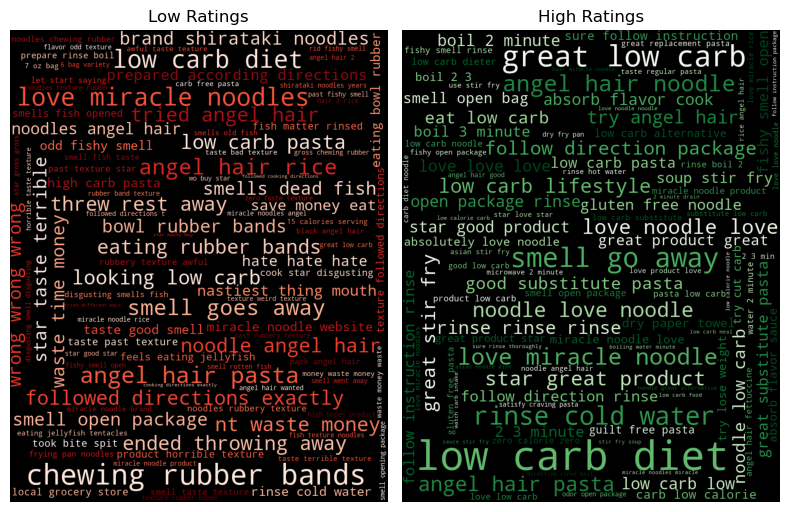

In [49]:
# Create an instance of a WordCloud and use the generate method
shared_cloud_kws = dict(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2,
                        collocations=False,
                        max_words=100,
                       stopwords=custom_stopwords
                       )

low_cloud = WordCloud(colormap="Reds", 
                      **shared_cloud_kws).generate_from_frequencies(low_freqs_dict_clean)
high_cloud = WordCloud(colormap="Greens",
                       **shared_cloud_kws).generate_from_frequencies(high_freqs_dict_clean)
fig = plot_wordclouds(low_cloud, high_cloud,figsize=(8,10), title=None)
fig.tight_layout()
fig.savefig(FPATHS['eda']['wordclouds']['trigram-clouds-by-group_png'], dpi=300, transparent=False, bbox_inches='tight')

In [50]:
from nltk import FreqDist

# Ngram Analysis - NLTK

In [51]:
import pandas as pd
import nltk
def get_ngram_measures_df(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words', return_finder_measures = False,
                         group_name = None, join_words = True, sep= " ", multi_index=False):
    """
    Return the desired ngrams dataframe of requested measure. 
    Alternatively, return the finder and measure classes.

    This function will be used as a helper function for a comparison function.
    """
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    # instantiate the selected MeasuresClass
    measures = MeasuresClass()
    # instantiate a Finder
    finder = FinderClass.from_words(tokens)
    # Apply frequency filtering
    finder.apply_freq_filter(min_freq)

    # Return finder and measures instead of 
    if return_finder_measures == True:
        return finder, measures

    # Select desired measure to return
    selected_measure = getattr(measures, measure)
    scored_ngrams = finder.score_ngrams(selected_measure)

    if group_name is not None:
        suffix = group_name.title()
        measure_name = f"{measure.replace('_',' ').title()}"

        if multi_index == True:
            columns =  pd.MultiIndex.from_arrays([(suffix,suffix),(words_colname,measure_name )])
        else:
            columns = [f"{words_colname} ({suffix})", f"{measure_name} ({suffix})"]
    else:
        columns=[words_colname, measure.replace('_',' ').title()]
    # Convert the Scored n-grams to a dataframe
    df_ngrams = pd.DataFrame(scored_ngrams, columns=columns)

    # Clean up ngrams 
    if join_words == True:
        df_ngrams[columns[0]] = df_ngrams[columns[0]].map(sep.join)
    
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams



In [52]:
finder,measures = get_ngram_measures_df(low_review_tokens_list, return_finder_measures=True)
# getattr(measures, 'pmi')

In [53]:
bigrams_high = get_ngram_measures_df(high_review_lemmas_list, top_n=5, group_name='High Reviews',multi_index=False)
bigrams_high

,Words (High Reviews),Raw Freq (High Reviews)
0,low carb,0.006091
1,angel hair,0.003348
2,miracle noodle,0.003328
3,stir fry,0.003065
4,taste like,0.002521


In [54]:
bigrams_high = get_ngram_measures_df(high_review_lemmas_list, top_n=5, group_name='High Reviews',multi_index=True)
bigrams_high

High Reviews          
            Words  Raw Freq
0        low carb  0.006091
1      angel hair  0.003348
2  miracle noodle  0.003328
3        stir fry  0.003065
4      taste like  0.002521

In [55]:
bigrams_low = get_ngram_measures_df(low_review_tokens_list, top_n=5)
bigrams_low

,Words,Raw Freq
0,like eating,0.003295
1,taste like,0.003214
2,texture like,0.002685
3,angel hair,0.002482
4,like fish,0.002360


In [56]:
def compare_ngram_measures_df(group1_tokens, group2_tokens, ngrams=2,
                              measure='raw_freq', min_freq = 1, top_n=25,
                             words_colname='Words', group1_name=None, group2_name=None, 
                             multi_index=True):
    """Compare 2 groups ngrams side-by-side"""
    
    group1_df = get_ngram_measures_df(group1_tokens,
                                      ngrams=ngrams,
                                      measure=measure,
                                      top_n=top_n,
                                      words_colname=words_colname,group_name=group1_name, multi_index=multi_index)
                                    
    group2_df = get_ngram_measures_df(group2_tokens,
                                      ngrams=ngrams,
                                      measure=measure,
                                      top_n=top_n,words_colname=words_colname,group_name=group2_name, multi_index=multi_index)  
    return pd.concat([group1_df, group2_df],axis=1)
    

In [57]:
def plot_group_ngrams( ngram_df, group1_colname = 'Low Ratings',
                      group2_colname= 'High Ratings',words_colname="Words",
                       plot_col="Raw Freq",top_n=None,
                      color_group1 = 'crimson', color_group2="green",
                      figsize=(12, 8),suptitle_kws={},suptitle_y= 1.01, rotation = 45):
    ### Plotting as Bar Graph
    if top_n == None:
        top_n = len(ngram_df)
        
    eda_ngrams_grp1 = ngram_df[group1_colname].set_index(words_colname)
    eda_ngrams_grp1 = eda_ngrams_grp1.sort_values(plot_col, ascending=True).tail(top_n)

    eda_ngrams_grp2 = ngram_df[group2_colname].set_index(words_colname)
    eda_ngrams_grp2 = eda_ngrams_grp2.sort_values(plot_col, ascending=True).tail(top_n)
                                                                            

    ## Plot the ngram frequencies
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    #
    eda_ngrams_grp1[plot_col].plot( kind="barh", 
                                   title=f"Top {top_n} n-grams for {group1_colname}",# (by {plot_col})", 
                                   ax=axes[0], 
                                   color=color_group1
                                  )
    eda_ngrams_grp2[plot_col].plot( kind="barh", 
                                   title=f"Top {top_n} n-grams for {group2_colname}",# (by {plot_col})", 
                                   ax=axes[1], 
                                   color=color_group2
                                  )
    # Set suptitle
    # determine which type of ngrams
    n_words = len(eda_ngrams_grp1.index[0].split(" "))
    if n_words == 2:
        ngrams = "Bigrams"
    elif n_words == 3:
        ngrams = "Trigrams"
    elif n_words == 4:
        ngrams = "Quadgrams"
    else:
        raise Exception(f"ngrams is {n_words}")
        
    
    fig.suptitle(f"Group {ngrams} by {plot_col}", y=suptitle_y, **suptitle_kws )
    for ax in axes:
        ax.spines["top"].set_visible(False)  # Remove the top spine
        ax.set_xlabel(plot_col) # Add the Measure label
        ax.spines["right"].set_visible(False)  # Remove the right spine
        
        # Fix label rotation
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right')
    fig.tight_layout()
    return fig

## Comparing ngrams - Raw Frequency

### Bigrams

In [58]:
# Calculate Bigrams
top_n = 25
df_bigrams = compare_ngram_measures_df(
    low_review_tokens_list,
    high_review_tokens_list,
    ngrams=2,
    min_freq=2,
    top_n=top_n,
    group1_name="Low Ratings",
    group2_name="High Ratings",
)
# Save to markdown for README
df_bigrams.to_markdown(FPATHS['eda']['bigrams']['ngram-table_md'])
df_bigrams

Low Ratings                 High Ratings          
                  Words  Raw Freq              Words  Raw Freq
0           like eating  0.003295           low carb  0.005909
1            taste like  0.003214         angel hair  0.003348
2          texture like  0.002685    miracle noodles  0.003065
3            angel hair  0.002482           stir fry  0.002319
4             like fish  0.002360       love noodles  0.002057
5              low carb  0.002116        fishy smell  0.001835
6       miracle noodles  0.002075         taste like  0.001795
7          rubber bands  0.002034          carb diet  0.001714
8          like texture  0.001790     miracle noodle  0.001674
9           waste money  0.001790        stars great  0.001634
10          fishy smell  0.001709        gluten free  0.001392
11          like rubber  0.001709       rice noodles  0.001331
12           smell like  0.001709      great product  0.001311
13          tastes like  0.001709  follow directions  0.001230
14         like chewing  0.001546          goes away  0.001190
15       miracle noodle  0.001546   great substitute  0.001190
16        taste texture  0.001546         stars love  0.001170
17          smells like  0.001424         cold water  0.001150
18          wanted like  0.001424        low calorie  0.001150
19         like noodles  0.001139      noodles great  0.001150
20  followed directions  0.001098       noodles love  0.001150
21    shirataki noodles  0.001017      regular pasta  0.001150
22           star taste  0.001017          great low  0.001008
23           taste good  0.001017       noodles rice  0.001008
24           like pasta  0.000976         guilt free  0.000988

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_2467/2433107546.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right')


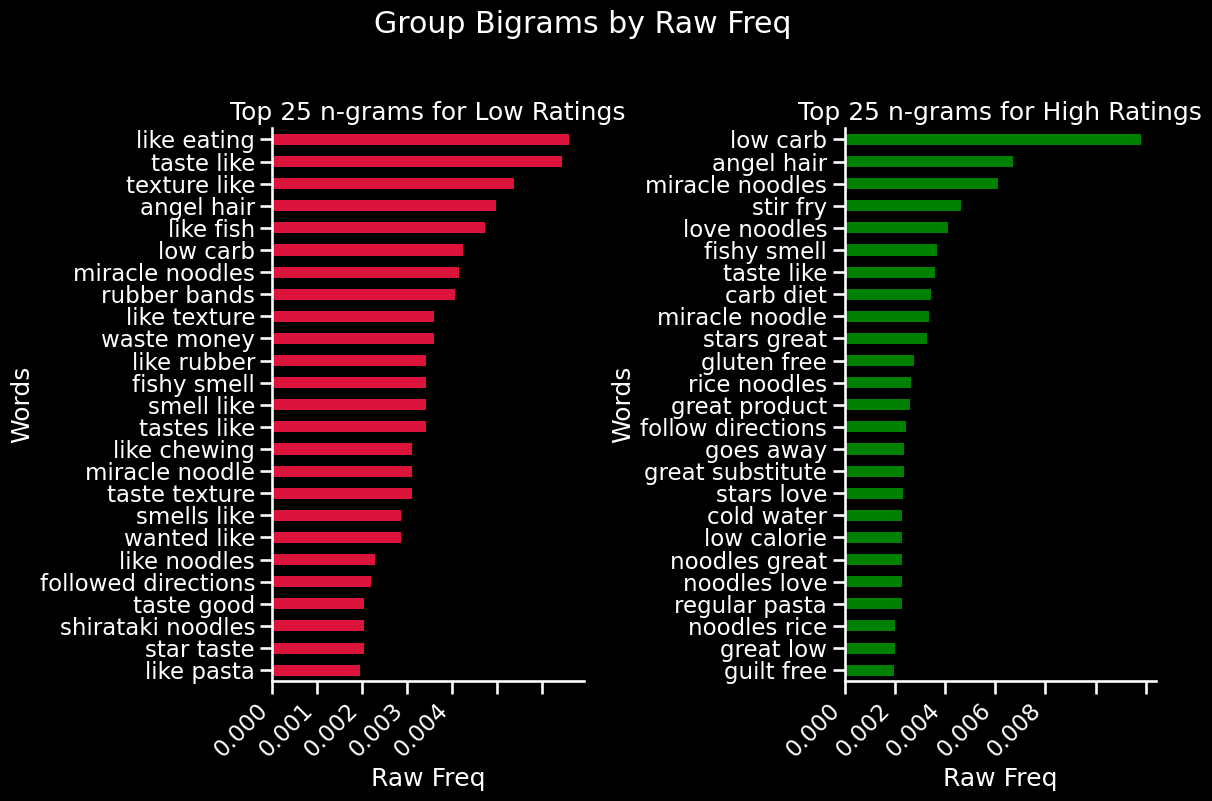

In [59]:
with plt.style.context(['dark_background',]):
    with sns.plotting_context("talk"):
        fig = plot_group_ngrams(df_bigrams)
fig.savefig(FPATHS['eda']['bigrams']['ngram-fig_png'], dpi=300, transparent=False, bbox_inches='tight')

### Trigrams

In [60]:
df_trigrams = compare_ngram_measures_df(
    low_review_tokens_list,
    high_review_tokens_list,
    ngrams=3,
    min_freq=2,
    top_n=top_n,
    group1_name="Low Ratings",
    group2_name="High Ratings",
)
df_trigrams.to_markdown(FPATHS['eda']['trigrams']['ngram-table_md'])

df_trigrams

Low Ratings                     High Ratings          
                    Words  Raw Freq                  Words  Raw Freq
0         smell like fish  0.000732          low carb diet  0.001533
1        smells like fish  0.000692         great low carb  0.000787
2     like chewing rubber  0.000610        smell goes away  0.000625
3      like eating rubber  0.000529   love miracle noodles  0.000484
4     texture like rubber  0.000529       rinse cold water  0.000484
5       smelled like fish  0.000488     angel hair noodles  0.000444
6    chewing rubber bands  0.000448   noodles love noodles  0.000403
7          like dead fish  0.000407       angel hair pasta  0.000383
8    love miracle noodles  0.000325    stars great product  0.000363
9           low carb diet  0.000325      love noodles love  0.000343
10       angel hair pasta  0.000285     like regular pasta  0.000303
11      like eating worms  0.000285     low carb lifestyle  0.000303
12          like old fish  0.000285      rinse rinse rinse  0.000262
13       like rotten fish  0.000285       taste like pasta  0.000262
14      taste like eating  0.000285       feel like eating  0.000242
15     tasted like rubber  0.000285  good substitute pasta  0.000242
16    texture like eating  0.000285     taste exactly like  0.000242
17        angel hair rice  0.000244       tried angel hair  0.000242
18      gross like eating  0.000244      like rice noodles  0.000222
19  like eating jellyfish  0.000244         love love love  0.000222
20   like texture noodles  0.000244           low carb low  0.000222
21     like texture taste  0.000244       noodles low carb  0.000222
22        smell goes away  0.000244        smell like fish  0.000222
23       taste like pasta  0.000244            2 3 minutes  0.000202
24    tastes like plastic  0.000244    great product great  0.000202

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_2467/2433107546.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right')


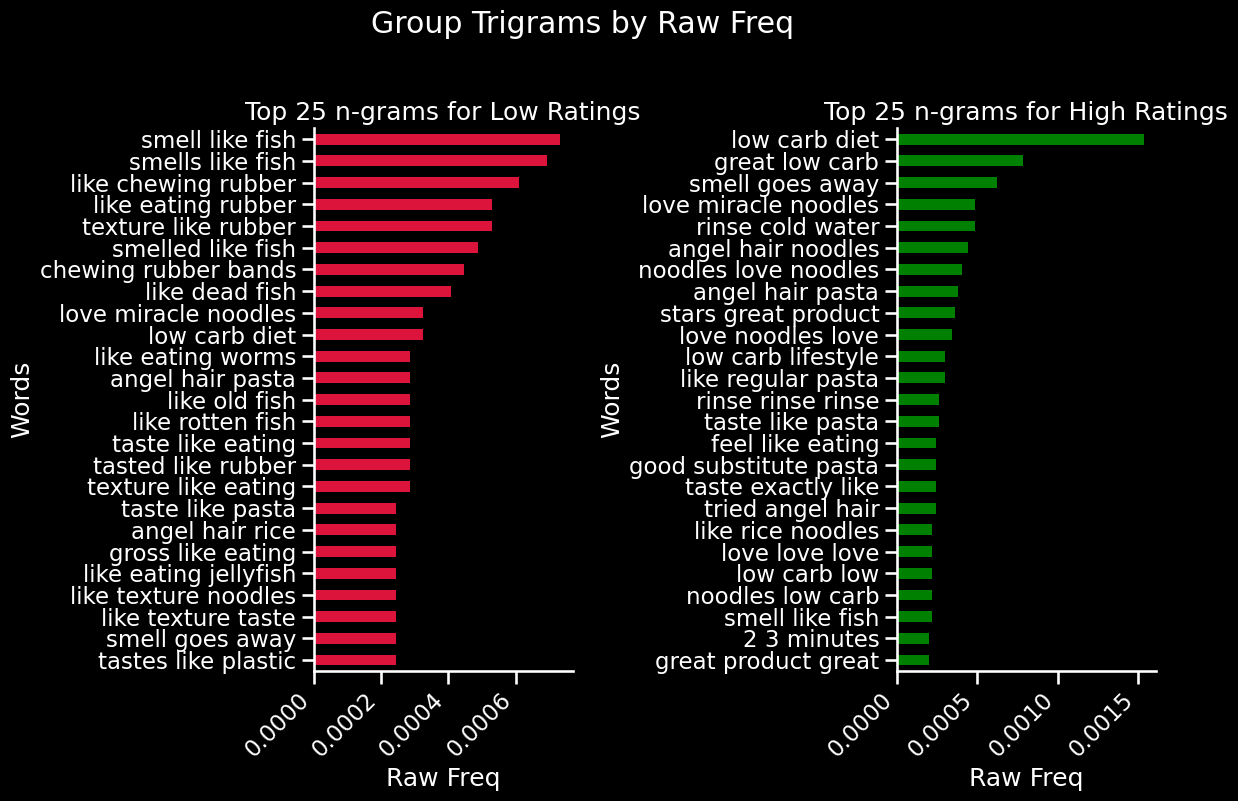

In [61]:
with plt.style.context(['dark_background',]):
    with sns.plotting_context("talk"):
        fig = plot_group_ngrams(df_trigrams)
fig.savefig(FPATHS['eda']['trigrams']['ngram-fig_png'], dpi=300, transparent=False, bbox_inches='tight')

### Quadgrams

In [62]:
df_quad_grams = compare_ngram_measures_df(
    low_review_tokens_list,
    high_review_tokens_list,
    ngrams=4,
    min_freq=2,
    top_n=top_n,
    group1_name="Low Ratings",
    group2_name="High Ratings",
)
df_quad_grams.to_markdown(FPATHS['eda']['quadgrams']['ngram-table_md'])
df_quad_grams

Low Ratings            \
                                   Words  Raw Freq   
0              like chewing rubber bands  0.000325   
1               like eating rubber bands  0.000203   
2                  smells like dead fish  0.000163   
3                      angel hair 2 rice  0.000122   
4          brand shirataki noodles asian  0.000122   
5            disgusting smells like fish  0.000122   
6               eating bowl rubber bands  0.000122   
7            feels like eating jellyfish  0.000122   
8    followed cooking directions exactly  0.000122   
9              gross like chewing rubber  0.000122   
10                   hate hate hate hate  0.000122   
11               like eating bowl rubber  0.000122   
12                 like tried angel hair  0.000122   
13            miracle noodles angel hair  0.000122   
14           noodles like chewing rubber  0.000122   
15               opened bag smelled like  0.000122   
16  previously purchased brand shirataki  0.000122   
17     purchased brand shirataki noodles  0.000122   
18                 smell like fish taste  0.000122   
19               smells like fish opened  0.000122   
20                  smells like old fish  0.000122   
21                 wanted like feel like  0.000122   
22               waste money waste money  0.000122   
23                      $ 64 pound fiber  0.000081   
24                  100 like fish finish  0.000081   

                     High Ratings            
                            Words  Raw Freq  
0       love noodles love noodles  0.000303  
1            low carb low calorie  0.000161  
2             great low carb diet  0.000141  
3        taste like regular pasta  0.000141  
4       great low carb substitute  0.000121  
5           low carb diet noodles  0.000121  
6       stars great product stars  0.000121  
7     great product great product  0.000101  
8       love miracle noodles love  0.000101  
9           noodles low carb diet  0.000101  
10     angel hair miracle noodles  0.000081  
11               boil 2 3 minutes  0.000081  
12        boiling water 2 minutes  0.000081  
13     exactly like regular pasta  0.000081  
14           great low carb diets  0.000081  
15     love noodles noodles great  0.000081  
16      love product love product  0.000081  
17           low calorie low carb  0.000081  
18    noodles stars great product  0.000081  
19          product low carb diet  0.000081  
20       substitute low carb diet  0.000081  
21     taste exactly like regular  0.000081  
22       zero calories zero carbs  0.000081  
23  alternative high carb noodles  0.000061  
24       angel hair pasta version  0.000061

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_2467/2433107546.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right')


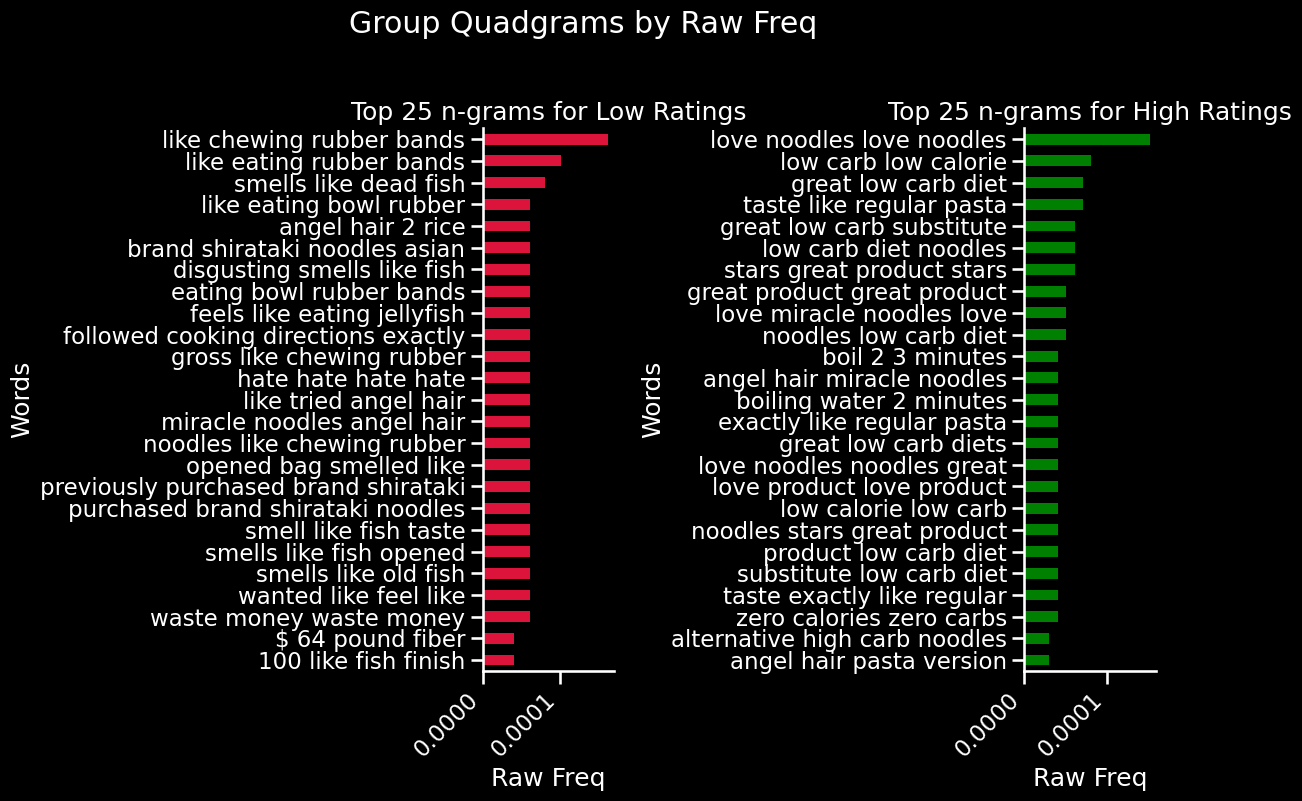

In [63]:
with plt.style.context(['dark_background',]):
    with sns.plotting_context("talk"):
        fig = plot_group_ngrams(df_quad_grams)
fig.savefig(FPATHS['eda']['quadgrams']['ngram-fig_png'], dpi=300, transparent=False, bbox_inches='tight')

## Part 3: Scattertext

In [64]:
df.columns

Index(['asin', 'reviewerID', 'reviewText', 'summary', 'overall', 'year',
       'title', 'brand', 'category', 'review-text-full',
       'review-text-full_raw', 'tokens-dirty', 'tokens', 'lemmas',
       'tokens-dirty-joined', 'tokens-joined', 'lemmas-joined',
       'target-rating'],
      dtype='object')

In [65]:
# target_col = "target-rating"
target_col = 'target-rating'
text_col ='review-text-full'
df[target_col].value_counts()

High    1868
Low     1437
Name: target-rating, dtype: int64

In [66]:
# df_eda = df.loc[ df[target_col]!='1_Successful']
# df_eda[target_col].value_counts(dropna=False)

In [67]:
import scattertext
from scattertext import (
    SampleCorpora,
    produce_scattertext_explorer,
    produce_scattertext_html,
)
from scattertext.CorpusFromPandas import CorpusFromPandas

In [68]:
nlp = ds.nlp.make_custom_nlp(disable=['ner'],contractions=[],
                             # stopwords_to_add=['film','movie','review']
                            )
nlp

In [69]:
# Build the scattertext corpus object
corpus = scattertext.CorpusFromPandas(
    df, category_col=target_col,
    text_col=text_col, 
    nlp=nlp
).build().remove_terms(nlp.Defaults.stop_words, ignore_absences = True)

In [70]:
# Create html visualization
# Provide file path to save
scatter_fname = FPATHS["eda"]["scattertext-by-group_html"]
scatter_fname

'eda/scattertext.html'

In [71]:
scatter_meta_cols = ['title','brand','year','overall',]
df

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...,None
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shira...,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Go for the green noodles: The herb flavor make...,Go for the green noodles: The herb flavor make...,"[go, for, the, green, noodles, the, herb, flav...","[green, noodles, herb, flavor, makes, odd, tex...","[green, noodle, herb, flavor, make, odd, textu...",go for the green noodles the herb flavor makes...,green noodles herb flavor makes odd texture sh...,green noodle herb flavor make odd texture shir...,High
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half fil...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Its an awesome substitute.: I didn't have a pr...,Its an awesome substitute.: I didn't have a pr...,"[its, an, awesome, substitute, i, did, n't, ha...","[awesome, substitute, problem, half, filled, b...","[awesome, substitute, problem, half, fill, bag...",its an awesome substitute i did n't have a pro...,awesome substitute problem half filled bag use...,awesome substitute problem half fill bag user ...,High
4,B007JINB0W,AH3B94LQOPPY6,They taste like whatever you cook them with.,Five Stars,5,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Five Stars: They taste like whatever you cook ...,Five Stars: They taste like whatever you cook ...,"[five, stars, they, taste, like, whatever, you...","[stars, taste, like, cook]","[star, taste, like, cook]",five stars they taste like whatever you cook t...,stars taste like cook,star taste like cook,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,A73IG1ED6S0JR,Product arrived with two of the bags punctured...,would not recomend,1,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,would not recomend: Product arrived with two o...,would not recomend: Product arrived with two o...,"[would, not, recomend, product, arrived, with,...","[recomend, product, arrived, bags, punctured, ...","[recomend, product, arrive, bag, puncture, sme...",would not recomend product arrived with two of...,recomend product arrived bags punctured smells...,recomend product arrive bag puncture smell bad,Low
4359,B007JINB0W,A1XZ2H0MYG54M0,Ok.,Fiv

In [72]:
df['target-rating']

0       None
1       None
2       High
3       High
4       High
        ... 
4358     Low
4359    High
4360     Low
4361     Low
4362    High
Name: target-rating, Length: 4363, dtype: object

In [73]:
scatter_html = scattertext.produce_scattertext_explorer(
    corpus,
    category="High",
    category_name="High Rating Reviews",
    not_category_name="Low Rating Reviews",
    protocol='http',
    minimum_term_frequency=3, 
    max_terms=50_000,#50_000, # Added to speed up loading in streamlit
    max_docs_per_category=1_000,#500, #Added to speed up loading in streamlit
    width_in_pixels=1000, # Setting a fixed width of 1000 pixels
    metadata=df[scatter_meta_cols]
)
open(scatter_fname, "wb").write(scatter_html.encode("utf-8"))
print(f"Open {scatter_fname} in Chrome or Firefox.")

Open eda/scattertext.html in Chrome or Firefox.


In [74]:
!open ./eda

# BOOKMARK EOD 02/08/24

## Sentiment Analysis - NLTK's Vader

Perform sentiment analysis to create polarity scores according to VADERS's sentiment lexicon.  
- Compare the sentiments of high-rating and low-rating texts.  
- Compare the average scores for high and low-rating reviews.  
- Which review polarity scores don't match the ratings?  Why do you think this is?

In [75]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/codingdojo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [76]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [77]:
df.head(2)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...,None


In [78]:
df['sentiment_scores'] = df['review-text-full'].map(sia.polarity_scores)
# Convert the column of dictionaries into separate columns
vader_scores = df['sentiment_scores'].apply(pd.Series)
# Join the new DataFrame with the original DataFrame
df_sentiment = pd.concat([df, vader_scores], axis=1).drop('sentiment_scores', axis=1)
df_sentiment

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating,neg,neu,pos,compound
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong,None,0.000,0.831,0.169,0.4295
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...,None,0.157,0.709,0.135,-0.1594
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shira...,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Go for the green noodles: The herb flavor make...,Go for the green noodles: The herb flavor make...,"[go, for, the, green, noodles, the, herb, flav...","[green, noodles, herb, flavor, makes, odd, tex...","[green, noodle, herb, flavor, make, odd, textu...",go for the green noodles the herb flavor makes...,green noodles herb flavor makes odd texture sh...,green noodle herb flavor make odd texture shir...,High,0.114,0.743,0.143,0.1513
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half fil...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Its an awesome substitute.: I didn't have a pr...,Its an awesome substitute.: I didn't have a pr...,"[its, an, awesome, substitute, i, did, n't, ha...","[awesome, substitute, problem, half, filled, b...","[awesome, substitute, problem, half, fill, bag...",its an awesome substitute i did n't have a pro...,awesome substitute problem half filled bag use...,awesome substitute problem half fill bag user ...,High,0.072,0.735,0.193,0.8936
4,B007JINB0W,AH3B94LQOPPY6,They taste like whatever you cook them with.,Five Stars,5,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Five Stars: They taste like whatever you cook ...,Five Stars: They taste like whatever you cook ...,"[five, stars, they, taste, like, whatever, you...","[stars, taste, like, cook]","[star, taste, like, cook]",five stars they taste like whatever you cook t...,stars taste like cook,star taste like cook,High,0.000,0.783,0.217,0.3612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,A73IG1ED6S0JR,Product arrived with two of the bags punctured...,would not recomend,1,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,would not recomend: Product arrived with two o...,would not recomend: Product arrived with two o...,"[would, not, recomend, product, arrived, with,...","[recomend, product, arrived, bags, punctured, ...","[recomend, product, arrive, bag, puncture, sme...",would not recomend product

In [79]:
# Define filter for positive reviews
pos_sentiment_reviews = df_sentiment['compound'] > 0
pos_sentiment_reviews.sum()

3023

In [80]:
df_sentiment

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating,neg,neu,pos,compound
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong,None,0.000,0.831,0.169,0.4295
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...,None,0.157,0.709,0.135,-0.1594
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shira...,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Go for the green noodles: The herb flavor make...,Go for the green noodles: The herb flavor make...,"[go, for, the, green, noodles, the, herb, flav...","[green, noodles, herb, flavor, makes, odd, tex...","[green, noodle, herb, flavor, make, odd, textu...",go for the green noodles the herb flavor makes...,green noodles herb flavor makes odd texture sh...,green noodle herb flavor make odd texture shir...,High,0.114,0.743,0.143,0.1513
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half fil...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Its an awesome substitute.: I didn't have a pr...,Its an awesome substitute.: I didn't have a pr...,"[its, an, awesome, substitute, i, did, n't, ha...","[awesome, substitute, problem, half, filled, b...","[awesome, substitute, problem, half, fill, bag...",its an awesome substitute i did n't have a pro...,awesome substitute problem half filled bag use...,awesome substitute problem half fill bag user ...,High,0.072,0.735,0.193,0.8936
4,B007JINB0W,AH3B94LQOPPY6,They taste like whatever you cook them with.,Five Stars,5,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Five Stars: They taste like whatever you cook ...,Five Stars: They taste like whatever you cook ...,"[five, stars, they, taste, like, whatever, you...","[stars, taste, like, cook]","[star, taste, like, cook]",five stars they taste like whatever you cook t...,stars taste like cook,star taste like cook,High,0.000,0.783,0.217,0.3612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,A73IG1ED6S0JR,Product arrived with two of the bags punctured...,would not recomend,1,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,would not recomend: Product arrived with two o...,would not recomend: Product arrived with two o...,"[would, not, recomend, product, arrived, with,...","[recomend, product, arrived, bags, punctured, ...","[recomend, product, arrive, bag, puncture, sme...",would not recomend product

> To Do: Add Plotting Sentiment Scores

## Sentiment - HuggingFace Pipelines

In [81]:
from transformers import pipeline
model = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_analyzer = pipeline(task="sentiment-analysis",model=model)

In [82]:
sentiment_analyzer("I think i enjoy it when I am being beat up")

[{'label': 'POSITIVE', 'score': 0.9991825222969055}]

In [83]:
df['review-text-full'].isna().sum()

0

In [84]:
test_text = df.loc[0,'review-text-full']
test_text

'Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!'

In [85]:
sentiment_analyzer(test_text)

[{'label': 'NEGATIVE', 'score': 0.9755984544754028}]

In [86]:
sentiment_results = []
for i in df.index:
    text = df.loc[i, 'review-text-full']
    try:
        sent = sentiment_analyzer(text)[0]
        
    except Exception as e:
        display(e)
        sent = {'label':pd.NA,'score':pd.NA}
    finally:
        sentiment_results.append(sent)
        

# sentiment_results = df['review-text-full'].map(lambda x: sentiment_analyzer(x))
len(sentiment_results)

Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


RuntimeError('The size of tensor a (844) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (896) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (627) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (1071) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (782) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (1673) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (542) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (598) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (1321) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (883) must match the size of tensor b (512) at non-singleton dimension 1')

RuntimeError('The size of tensor a (781) must match the size of tensor b (512) at non-singleton dimension 1')

4363

In [87]:
pd.DataFrame(sentiment_results)

,label,score
0,NEGATIVE,0.975598
1,NEGATIVE,0.928574
2,POSITIVE,0.998185
3,POSITIVE,0.956252
4,POSITIVE,0.976258
...,...,...
4358,NEGATIVE,0.99955
4359,POSITIVE,0.999738
4360,NEGATIVE,0.998457
4361,NEGATIVE,0.998849


In [88]:
sentiment_df = pd.DataFrame(sentiment_results[0])
sentiment_df.loc[0]

ValueError: If using all scalar values, you must pass an index

In [ ]:
df_full = pd.concat([df, sentiment_df],axis=1)
df_full